# Code Autocompletion with n-grams

We frame the code autocompletion task as follows: given a sequence of $n$ tokens (which you can consider $n$ words of code), predict the $n+1$th token. With this interpretation of the problem in mind, we can use a simple n-gram based maximum likelihood predictor as a rough heuristic for code autocompletion. There are many issues with this approach, but it helps build the intuition of *next token prediction.* Next token prediction is the underlying concept behind Large Language Models, and is one approach that we will be using to solve the code autocompletion problem.

---

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import regex as re
from datasets import load_dataset, Dataset

c:\Users\amira\OneDrive\Documents\GitHub\Projects\mini-copilot\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, we can start by pulling our dataset.

In [2]:
def get_data(n: int) -> Dataset:
    """Pull n samples of the codeparrot dataset onto memory, after filtering for Python code."""
    # https://huggingface.co/datasets/codeparrot/github-code
    # Load the dataset
    ds = load_dataset("codeparrot/github-code", streaming=True, split="train")
    ds = ds.filter(lambda x: x["language"] == "Python")

    ds = ds.take(n)

    return ds

dataset = get_data(1_000)

next(iter(dataset))

{'code': 'from django import forms\nfrom django.core.exceptions import ValidationError\nfrom django.core.validators import validate_slug\nfrom django.db import models\nfrom django.utils import simplejson as json\nfrom django.utils.text import capfirst\nfrom django.utils.translation import ugettext_lazy as _\n\nfrom philo.forms.fields import JSONFormField\nfrom philo.utils.registry import RegistryIterator\nfrom philo.validators import TemplateValidator, json_validator\n#from philo.models.fields.entities import *\n\n\nclass TemplateField(models.TextField):\n\t"""A :class:`TextField` which is validated with a :class:`.TemplateValidator`. ``allow``, ``disallow``, and ``secure`` will be passed into the validator\'s construction."""\n\tdef __init__(self, allow=None, disallow=None, secure=True, *args, **kwargs):\n\t\tsuper(TemplateField, self).__init__(*args, **kwargs)\n\t\tself.validators.append(TemplateValidator(allow, disallow, secure))\n\n\nclass JSONDescriptor(object):\n\tdef __init__(se

Now, we need to tokenize our dataset, as the individual "grams" in our n-gram model is built upon tokens. If you are unfamiliar with tokenization, [this](https://medium.com/@abdallahashraf90x/tokenization-in-nlp-all-you-need-to-know-45c00cfa2df7) is a quick read and [this is](https://youtu.be/zduSFxRajkE?si=4TAlVacyZTNUmLn9) a long but incredibly comprehensive watch that you will not regret (Andrej Karpathy is the goat). If you are familiar with tokenization, you likely do not appreciate it enough.

There is a lot to consider when tokenizing a code dataset. For instance, we cannot just naively split based on whitespace - newlines and punctuation are quite important in code.

In [3]:
all_tokens = []

for example in dataset:
    code = example["code"]
    lines = re.split(r"(\n+)", code)
    for line in lines:
        tokens = re.split(r"(\p{P}|\s+)", line)
        for token in tokens:
            if token not in ["", " "]:
                all_tokens.append(token)

In [ ]:
for token in all_tokens[410:450]:
    print(token)

Now, we can build out our n-grams. In this notebook, we will use 3-grams, and only 3-grams. A better approach would be to leverage a mixture of uni, bi, tri, ..., n grams.

In [4]:
def get_ngrams(n: int, tokens: list) -> defaultdict:
    """Given a list of tokens, return a dictionary of all the n-grams from the tokens."""
    ngrams = []

    for i in range(len(tokens) - n + 1):
        ngrams.append(tokens[i:i+n])

    return ngrams

three_grams = get_ngrams(3, all_tokens)

Based on all of the 3-grams we have derived, we can build a simple count based model we can use to predict the next token given the past 2 tokens.

In [5]:
model_3gram = defaultdict(lambda: defaultdict(int))

for three_gram in three_grams:
    if len(three_gram) == 3:
        model_3gram[(three_gram[0], three_gram[1])][three_gram[2]] += 1

In [19]:
model_3gram[("def", "main")]

defaultdict(int, {'(': 64, '_': 1})

In [7]:
def plot_model(model: dict, w1: str, w2: str, top_n=10):
    """Plot the top_n words that follow the bigram (w1, w2) in the model."""
    words = [w for w, _ in sorted(model[(w1, w2)].items(), key=lambda x: x[1], reverse=True)[:top_n]]
    counts = [c for _, c in sorted(model[(w1, w2)].items(), key=lambda x: x[1], reverse=True)[:top_n]]
    colors = cm.rainbow(np.linspace(0, 1, len(words)))
    plt.bar(words, counts, color=colors)
    plt.xticks(rotation=45)
    plt.show()

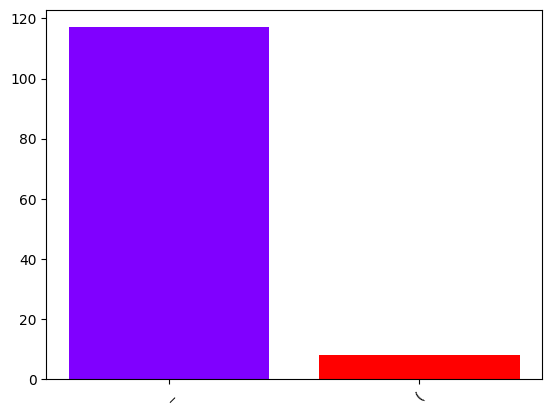

In [13]:
plot_model(model_3gram, "def", "add")

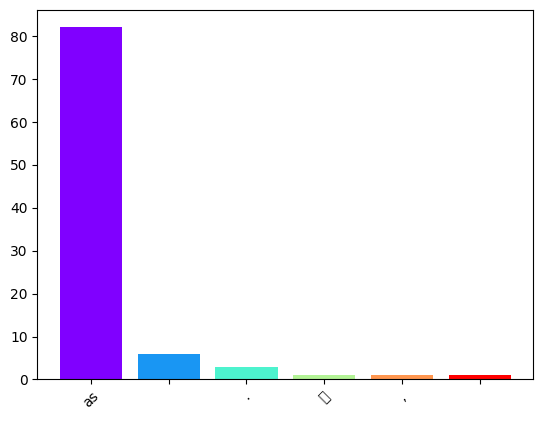

In [14]:
plot_model(model_3gram, "import", "numpy")

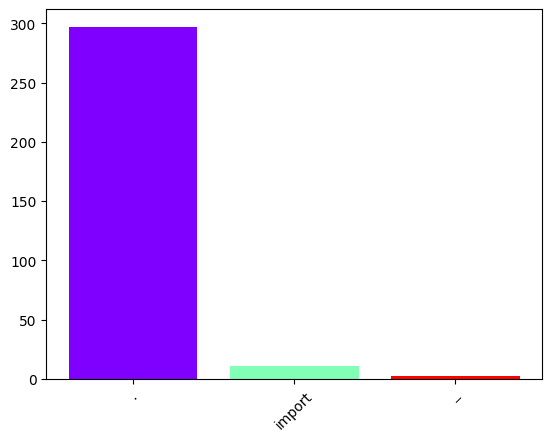

In [15]:
plot_model(model_3gram, "from", "django")

We can write a simple function that uses the most probable next token to generate a completion based on a provided input.

In [9]:
def generate(model: dict, w1: str, w2: str, n: int = 10) -> list:
    """Generate the next n token from the model, given the initial bigram (w1, w2)."""
    words = []
    for i in range(n):
        if not model[(w1, w2)]:
            break
        w3 = max(model[(w1, w2)], key=model[(w1, w2)].get)
        words.append(w3)
        w1, w2 = w2, w3
    return words

input_text = "def main"
input_text = input_text.split()
generate(model_3gram, *input_text, n=10)

['(', ')', '\n', '        ', '"', 'http', ':', '/', '/', 'thecolbertreport']

In [10]:
input_text = "import pandas"
input_text = input_text.split()
generate(model_3gram, *input_text, n=10)

['as', 'pd', '\n', 'import', 'os', '\n', 'import', 'os', '\n', 'import']